In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [9]:
batch_size = 64
num_epochs = 20
k_fold = 5

In [3]:
from typing import Dict, List, Literal
from sklearn.model_selection import KFold
import torch.utils.data.dataset
from torchvision import transforms

data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(342, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.RandomResizedCrop(299),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            # transforms.ConvertImageDtype(torch.float),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(342, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(299),
            transforms.ToTensor(),
            # transforms.ConvertImageDtype(torch.float),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    ),
}

dataDir = "Cat Breed Dataset"

full_dataset = torchvision.datasets.ImageFolder(dataDir)

kf = KFold(k_fold, shuffle=True)

dataloader: List[Dict[Literal["train", "val"], torch.utils.data.DataLoader]] = []

for fold, (train_index, val_index) in enumerate(kf.split(np.arange(len(full_dataset)))):
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_index)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_index)

    train_loader = torch.utils.data.DataLoader(full_dataset, batch_size=batch_size, sampler=train_subsampler, num_workers=8)
    val_loader = torch.utils.data.DataLoader(full_dataset, batch_size=batch_size, sampler=val_subsampler, num_workers=8)

    train_loader.dataset.transform = data_transforms["train"]
    val_loader.dataset.transform = data_transforms["val"]

    dataloader.append({"train": train_loader, "val": val_loader})

class_names = full_dataset.classes

In [4]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [5]:
def imshow(img: torch.Tensor, title=None):
    img = img.permute(1, 2, 0).detach().cpu().numpy()
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

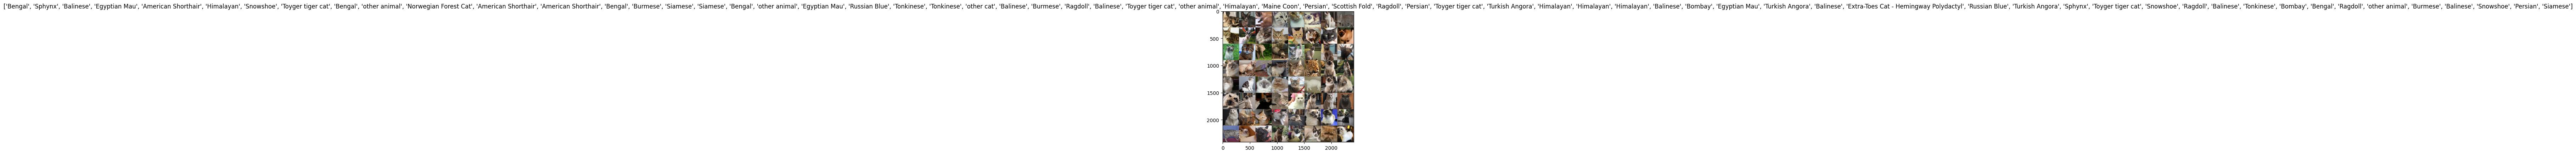

In [6]:
inputs, classes = next(iter(dataloader[0]['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [7]:
import copy
import time


def train_model_kfold(model, criterion, optimizer, scheduler, num_epochs, dataloader):
        since = time.time()
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        best_loss = 10000.0   # Large arbitrary number
        best_acc_train = 0.0
        best_loss_train = 10000.0  # Large arbitrary number
        print('Training started:')
        for epoch in range(num_epochs):
            dataset_sizes = {
                "train": len(dataloader['train']),
                "val": len(dataloader['val'])
            }

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    # Set model to training mode
                    model.train()
                else:
                    # Set model to evaluate mode
                    model.eval()

                # Iteration loop
                running_loss = 0.0
                running_corrects = 0
                n_batches = dataset_sizes[phase]
                it = 0
                for inputs, labels in dataloader[phase]:
                    since_batch = time.time()
                    batch_size_ = len(inputs)
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()

                    # Track/compute gradient and make an optimization step only when training
                    with torch.set_grad_enabled(phase == 'train'):
                        if phase == 'train':
                            outputs, aux_outputs = model(inputs)
                            loss1 = criterion(outputs, labels)
                            loss2 = criterion(aux_outputs, labels)
                            loss = loss1 + loss2 * 0.4
                        else:
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Print iteration results
                    running_loss += loss.item() * batch_size_
                    batch_corrects = torch.sum(preds == labels.data).item()
                    running_corrects += batch_corrects
                    print('\rPhase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}'.format(phase, epoch + 1, num_epochs, it + 1, n_batches + 1, time.time() - since_batch), end='', flush=True)
                    it += 1

                if phase == 'train':
                    scheduler.step()  # Update the learning rate

                print("", end='\r')
                # Print epoch results
                epoch_loss = running_loss / dataset_sizes[phase] / batch_size
                epoch_acc = running_corrects / dataset_sizes[phase] / batch_size
                print('Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}             '.format('train' if phase == 'train' else 'val ', epoch + 1, num_epochs, epoch_loss, epoch_acc))

                # Check if this is the best model wrt previous epochs
                if phase == 'val' and epoch_acc >= best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                if phase == 'train' and epoch_acc > best_acc_train:
                    best_acc_train = epoch_acc
                if phase == 'train' and epoch_loss < best_loss_train:
                    best_loss_train = epoch_loss

        # Print final results
        model.load_state_dict(best_model_wts)
        time_elapsed = time.time() - since
        print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val loss: {:.4f} | Best val accuracy: {:.4f}'.format(best_loss, best_acc))
        return model

In [10]:
from torchvision.models import inception_v3, Inception_V3_Weights
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler


model_weights = []

def build_model(num_classes):
    model = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(512, num_classes),
    )
    model.to(device)
    return model

for i, data in enumerate(dataloader):
    model = build_model(len(class_names))

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # 傳入所有的parameter，代表ResNet的部分也會訓練到
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    print("Training model {}/{}".format(i+1, len(dataloader)))
    model = train_model_kfold(model, criterion, optimizer, exp_lr_scheduler, num_epochs, data)

    model_weights.append(model.state_dict())
    torch.save(model.state_dict(), "inceptionv3_tree{}.pth".format(i))

Training model 0/5
Training started:
Phase: train Epoch: 1/20 Iter: 101/126 Batch time: 0.2216

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 1/20 Loss: 2.5911 Acc: 0.4440             
Phase: val  Epoch: 1/20 Loss: 2.5057 Acc: 0.3418             
Phase: train Epoch: 2/20 Iter: 19/126 Batch time: 0.2222

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 2/20 Loss: 1.7600 Acc: 0.5978             
Phase: val  Epoch: 2/20 Loss: 1.4933 Acc: 0.5190             
Phase: train Epoch: 3/20 Iter: 60/126 Batch time: 0.2225

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 3/20 Loss: 1.4516 Acc: 0.6591             
Phase: val  Epoch: 3/20 Loss: 1.4309 Acc: 0.5508             
Phase: train Epoch: 4/20 Iter: 72/126 Batch time: 0.2219

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 4/20 Loss: 1.1960 Acc: 0.7097             
Phase: val  Epoch: 4/20 Loss: 1.4694 Acc: 0.5396             
Phase: train Epoch: 5/20 Iter: 85/126 Batch time: 0.2225

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 5/20 Loss: 1.0993 Acc: 0.7214             
Phase: val  Epoch: 5/20 Loss: 1.4858 Acc: 0.5400             


/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 6/20 Loss: 0.8804 Acc: 0.7768             
Phase: val  Epoch: 6/20 Loss: 1.3427 Acc: 0.5854             
Phase: train Epoch: 7/20 Iter: 93/126 Batch time: 0.2244

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 7/20 Loss: 0.7470 Acc: 0.8021             
Phase: val  Epoch: 7/20 Loss: 1.5473 Acc: 0.5503             
Phase: train Epoch: 8/20 Iter: 66/126 Batch time: 0.2232

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 8/20 Loss: 0.6594 Acc: 0.8195             
Phase: val  Epoch: 8/20 Loss: 1.3295 Acc: 0.5898             
Phase: train Epoch: 9/20 Iter: 87/126 Batch time: 0.2225

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 9/20 Loss: 0.5668 Acc: 0.8438             
Phase: val  Epoch: 9/20 Loss: 1.5160 Acc: 0.6089             
Phase: train Epoch: 10/20 Iter: 28/126 Batch time: 0.2234

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 10/20 Loss: 0.4561 Acc: 0.8771             
Phase: val  Epoch: 10/20 Loss: 1.6364 Acc: 0.6045             
Phase: train Epoch: 11/20 Iter: 68/126 Batch time: 0.2230

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 11/20 Loss: 0.1921 Acc: 0.9480             
Phase: val  Epoch: 11/20 Loss: 1.3188 Acc: 0.6655             
Phase: train Epoch: 12/20 Iter: 83/126 Batch time: 0.2227

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 12/20 Loss: 0.0818 Acc: 0.9778             
Phase: val  Epoch: 12/20 Loss: 1.4097 Acc: 0.6616             
Phase: train Epoch: 13/20 Iter: 78/126 Batch time: 0.2224

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 13/20 Loss: 0.0536 Acc: 0.9865             
Phase: val  Epoch: 13/20 Loss: 1.4890 Acc: 0.6621             
Phase: train Epoch: 14/20 Iter: 18/126 Batch time: 0.2227

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 14/20 Loss: 0.0404 Acc: 0.9902             
Phase: val  Epoch: 14/20 Loss: 1.5371 Acc: 0.6621             
Phase: train Epoch: 15/20 Iter: 18/126 Batch time: 0.2229

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 15/20 Loss: 0.0262 Acc: 0.9950             
Phase: val  Epoch: 15/20 Loss: 1.6168 Acc: 0.6631             
Phase: train Epoch: 16/20 Iter: 102/126 Batch time: 0.2238

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 16/20 Loss: 0.0221 Acc: 0.9951             
Phase: val  Epoch: 16/20 Loss: 1.6768 Acc: 0.6626             
Phase: train Epoch: 17/20 Iter: 55/126 Batch time: 0.2223

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 17/20 Loss: 0.0197 Acc: 0.9964             
Phase: val  Epoch: 17/20 Loss: 1.7494 Acc: 0.6621             
Phase: train Epoch: 18/20 Iter: 32/126 Batch time: 0.2226

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 18/20 Loss: 0.0142 Acc: 0.9982             
Phase: val  Epoch: 18/20 Loss: 1.7659 Acc: 0.6592             
Phase: train Epoch: 19/20 Iter: 45/126 Batch time: 0.2214

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 19/20 Loss: 0.0140 Acc: 0.9981             
Phase: val  Epoch: 19/20 Loss: 1.8006 Acc: 0.6597             
Phase: train Epoch: 20/20 Iter: 69/126 Batch time: 0.2228

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 20/20 Loss: 0.0108 Acc: 0.9981             
Phase: val  Epoch: 20/20 Loss: 1.7958 Acc: 0.6655             
Training completed in 10m 58s
Best val loss: 1.3188 | Best val accuracy: 0.6655
Training model 1/5
Training started:
Phase: train Epoch: 1/20 Iter: 94/126 Batch time: 0.2219

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 1/20 Loss: 2.5932 Acc: 0.4427             
Phase: val  Epoch: 1/20 Loss: 1.6011 Acc: 0.5005             
Phase: train Epoch: 2/20 Iter: 21/126 Batch time: 0.2226

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 2/20 Loss: 1.7956 Acc: 0.5884             
Phase: val  Epoch: 2/20 Loss: 1.3286 Acc: 0.5674             
Phase: train Epoch: 3/20 Iter: 90/126 Batch time: 0.2229

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 3/20 Loss: 1.4665 Acc: 0.6541             
Phase: val  Epoch: 3/20 Loss: 1.5384 Acc: 0.5122             
Phase: train Epoch: 4/20 Iter: 34/126 Batch time: 0.2199

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 4/20 Loss: 1.2831 Acc: 0.6844             
Phase: val  Epoch: 4/20 Loss: 1.3077 Acc: 0.5811             
Phase: train Epoch: 5/20 Iter: 93/126 Batch time: 0.2225

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 5/20 Loss: 1.0393 Acc: 0.7366             
Phase: val  Epoch: 5/20 Loss: 1.2076 Acc: 0.5962             
Phase: train Epoch: 6/20 Iter: 28/126 Batch time: 0.2221

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 6/20 Loss: 0.8910 Acc: 0.7684             
Phase: val  Epoch: 6/20 Loss: 1.2922 Acc: 0.5967             
Phase: train Epoch: 7/20 Iter: 34/126 Batch time: 0.2206

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 7/20 Loss: 0.7853 Acc: 0.7873             
Phase: val  Epoch: 7/20 Loss: 1.3535 Acc: 0.5889             
Phase: train Epoch: 8/20 Iter: 7/126 Batch time: 0.2217

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 8/20 Loss: 0.6319 Acc: 0.8266             
Phase: val  Epoch: 8/20 Loss: 1.3531 Acc: 0.5972             
Phase: train Epoch: 9/20 Iter: 40/126 Batch time: 0.2233

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 9/20 Loss: 0.5319 Acc: 0.8535             
Phase: val  Epoch: 9/20 Loss: 1.4316 Acc: 0.5908             
Phase: train Epoch: 10/20 Iter: 71/126 Batch time: 0.2226

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 10/20 Loss: 0.4827 Acc: 0.8600             
Phase: val  Epoch: 10/20 Loss: 1.7789 Acc: 0.5552             
Phase: train Epoch: 11/20 Iter: 106/126 Batch time: 0.2219

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 11/20 Loss: 0.2326 Acc: 0.9381             
Phase: val  Epoch: 11/20 Loss: 1.2118 Acc: 0.6636             
Phase: train Epoch: 12/20 Iter: 97/126 Batch time: 0.2232

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 12/20 Loss: 0.1005 Acc: 0.9745             
Phase: val  Epoch: 12/20 Loss: 1.2943 Acc: 0.6675             
Phase: train Epoch: 13/20 Iter: 82/126 Batch time: 0.2212

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 13/20 Loss: 0.0599 Acc: 0.9875             
Phase: val  Epoch: 13/20 Loss: 1.3897 Acc: 0.6665             
Phase: train Epoch: 14/20 Iter: 99/126 Batch time: 0.2218

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 14/20 Loss: 0.0426 Acc: 0.9908             
Phase: val  Epoch: 14/20 Loss: 1.4663 Acc: 0.6655             
Phase: train Epoch: 15/20 Iter: 6/126 Batch time: 0.2233

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 15/20 Loss: 0.0312 Acc: 0.9949             
Phase: val  Epoch: 15/20 Loss: 1.5380 Acc: 0.6719             
Phase: train Epoch: 16/20 Iter: 21/126 Batch time: 0.2231

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 16/20 Loss: 0.0227 Acc: 0.9960             
Phase: val  Epoch: 16/20 Loss: 1.5832 Acc: 0.6689             
Phase: train Epoch: 17/20 Iter: 96/126 Batch time: 0.2235

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 17/20 Loss: 0.0177 Acc: 0.9972             
Phase: val  Epoch: 17/20 Loss: 1.6527 Acc: 0.6660             
Phase: train Epoch: 18/20 Iter: 1/126 Batch time: 0.2385

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 18/20 Loss: 0.0139 Acc: 0.9975             
Phase: val  Epoch: 18/20 Loss: 1.6914 Acc: 0.6655             
Phase: train Epoch: 19/20 Iter: 1/126 Batch time: 0.2388

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 19/20 Loss: 0.0133 Acc: 0.9975             
Phase: val  Epoch: 19/20 Loss: 1.7594 Acc: 0.6597             
Phase: train Epoch: 20/20 Iter: 104/126 Batch time: 0.2226

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 20/20 Loss: 0.0111 Acc: 0.9984             
Phase: val  Epoch: 20/20 Loss: 1.7735 Acc: 0.6646             
Training completed in 10m 56s
Best val loss: 1.2076 | Best val accuracy: 0.6719
Training model 2/5
Training started:
Phase: train Epoch: 1/20 Iter: 45/126 Batch time: 0.2221

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 1/20 Loss: 2.6605 Acc: 0.4334             
Phase: val  Epoch: 1/20 Loss: 1.7802 Acc: 0.4463             
Phase: train Epoch: 2/20 Iter: 2/126 Batch time: 0.2220

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 2/20 Loss: 1.8120 Acc: 0.5821             
Phase: val  Epoch: 2/20 Loss: 1.5292 Acc: 0.5112             
Phase: train Epoch: 3/20 Iter: 61/126 Batch time: 0.2222

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 3/20 Loss: 1.4698 Acc: 0.6520             
Phase: val  Epoch: 3/20 Loss: 1.4325 Acc: 0.5537             
Phase: train Epoch: 4/20 Iter: 80/126 Batch time: 0.2237

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 4/20 Loss: 1.2472 Acc: 0.6961             
Phase: val  Epoch: 4/20 Loss: 1.3667 Acc: 0.5815             
Phase: train Epoch: 5/20 Iter: 48/126 Batch time: 0.2216

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 5/20 Loss: 1.0476 Acc: 0.7368             
Phase: val  Epoch: 5/20 Loss: 1.4307 Acc: 0.5703             


/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 6/20 Loss: 0.9140 Acc: 0.7559             
Phase: val  Epoch: 6/20 Loss: 1.3310 Acc: 0.5957             
Phase: train Epoch: 7/20 Iter: 90/126 Batch time: 0.2228

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 7/20 Loss: 0.7664 Acc: 0.7943             
Phase: val  Epoch: 7/20 Loss: 1.6125 Acc: 0.5527             
Phase: train Epoch: 8/20 Iter: 53/126 Batch time: 0.2227

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 8/20 Loss: 0.6411 Acc: 0.8225             
Phase: val  Epoch: 8/20 Loss: 1.5394 Acc: 0.5981             
Phase: train Epoch: 9/20 Iter: 33/126 Batch time: 0.2226

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 9/20 Loss: 0.5612 Acc: 0.8464             
Phase: val  Epoch: 9/20 Loss: 1.5669 Acc: 0.5791             


/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 10/20 Loss: 0.4827 Acc: 0.8672             
Phase: val  Epoch: 10/20 Loss: 1.8035 Acc: 0.5547             
Phase: train Epoch: 11/20 Iter: 48/126 Batch time: 0.2224

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 11/20 Loss: 0.2089 Acc: 0.9440             
Phase: val  Epoch: 11/20 Loss: 1.3213 Acc: 0.6504             


/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 12/20 Loss: 0.0909 Acc: 0.9771             
Phase: val  Epoch: 12/20 Loss: 1.4005 Acc: 0.6626             
Phase: train Epoch: 13/20 Iter: 87/126 Batch time: 0.2215

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 13/20 Loss: 0.0569 Acc: 0.9871             
Phase: val  Epoch: 13/20 Loss: 1.5090 Acc: 0.6577             
Phase: train Epoch: 14/20 Iter: 72/126 Batch time: 0.2217

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 14/20 Loss: 0.0411 Acc: 0.9905             
Phase: val  Epoch: 14/20 Loss: 1.5702 Acc: 0.6567             
Phase: train Epoch: 15/20 Iter: 3/126 Batch time: 0.2221

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 15/20 Loss: 0.0297 Acc: 0.9936             
Phase: val  Epoch: 15/20 Loss: 1.6188 Acc: 0.6577             
Phase: train Epoch: 16/20 Iter: 41/126 Batch time: 0.2228

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 16/20 Loss: 0.0212 Acc: 0.9960             
Phase: val  Epoch: 16/20 Loss: 1.6810 Acc: 0.6567             
Phase: train Epoch: 17/20 Iter: 2/126 Batch time: 0.2228

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 17/20 Loss: 0.0178 Acc: 0.9966             
Phase: val  Epoch: 17/20 Loss: 1.7122 Acc: 0.6582             
Phase: train Epoch: 18/20 Iter: 79/126 Batch time: 0.2212

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 18/20 Loss: 0.0183 Acc: 0.9964             
Phase: val  Epoch: 18/20 Loss: 1.7562 Acc: 0.6587             
Phase: train Epoch: 19/20 Iter: 21/126 Batch time: 0.2236

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 19/20 Loss: 0.0135 Acc: 0.9979             
Phase: val  Epoch: 19/20 Loss: 1.7933 Acc: 0.6602             
Phase: train Epoch: 20/20 Iter: 97/126 Batch time: 0.2226

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 20/20 Loss: 0.0103 Acc: 0.9988             
Phase: val  Epoch: 20/20 Loss: 1.8224 Acc: 0.6582             
Training completed in 10m 54s
Best val loss: 1.3213 | Best val accuracy: 0.6626
Training model 3/5
Training started:
Phase: train Epoch: 1/20 Iter: 67/126 Batch time: 0.2220

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 1/20 Loss: 2.6645 Acc: 0.4279             
Phase: val  Epoch: 1/20 Loss: 1.4743 Acc: 0.5249             
Phase: train Epoch: 2/20 Iter: 6/126 Batch time: 0.2236

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 2/20 Loss: 1.7845 Acc: 0.5930             
Phase: val  Epoch: 2/20 Loss: 1.2995 Acc: 0.5605             
Phase: train Epoch: 3/20 Iter: 37/126 Batch time: 0.2252

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 3/20 Loss: 1.4593 Acc: 0.6506             
Phase: val  Epoch: 3/20 Loss: 1.6246 Acc: 0.5078             
Phase: train Epoch: 4/20 Iter: 30/126 Batch time: 0.2217

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 4/20 Loss: 1.2446 Acc: 0.6911             
Phase: val  Epoch: 4/20 Loss: 1.5068 Acc: 0.5649             
Phase: train Epoch: 5/20 Iter: 45/126 Batch time: 0.2235

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 5/20 Loss: 1.0720 Acc: 0.7232             
Phase: val  Epoch: 5/20 Loss: 1.4281 Acc: 0.5596             
Phase: train Epoch: 6/20 Iter: 42/126 Batch time: 0.2226

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 6/20 Loss: 0.9234 Acc: 0.7649             
Phase: val  Epoch: 6/20 Loss: 1.5158 Acc: 0.5811             
Phase: train Epoch: 7/20 Iter: 15/126 Batch time: 0.2234

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 7/20 Loss: 0.7222 Acc: 0.8040             
Phase: val  Epoch: 7/20 Loss: 1.4001 Acc: 0.5986             
Phase: train Epoch: 8/20 Iter: 20/126 Batch time: 0.2239

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 8/20 Loss: 0.6350 Acc: 0.8241             
Phase: val  Epoch: 8/20 Loss: 1.2639 Acc: 0.6206             
Phase: train Epoch: 9/20 Iter: 1/126 Batch time: 0.2386

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 9/20 Loss: 0.5437 Acc: 0.8490             
Phase: val  Epoch: 9/20 Loss: 1.6686 Acc: 0.5889             
Phase: train Epoch: 10/20 Iter: 45/126 Batch time: 0.2227

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 10/20 Loss: 0.4988 Acc: 0.8629             
Phase: val  Epoch: 10/20 Loss: 1.5026 Acc: 0.5923             
Phase: train Epoch: 11/20 Iter: 26/126 Batch time: 0.2229

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 11/20 Loss: 0.2149 Acc: 0.9437             
Phase: val  Epoch: 11/20 Loss: 1.2101 Acc: 0.6719             
Phase: train Epoch: 12/20 Iter: 21/126 Batch time: 0.2237

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 12/20 Loss: 0.0966 Acc: 0.9770             
Phase: val  Epoch: 12/20 Loss: 1.3000 Acc: 0.6777             
Phase: train Epoch: 13/20 Iter: 58/126 Batch time: 0.2230

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 13/20 Loss: 0.0625 Acc: 0.9844             
Phase: val  Epoch: 13/20 Loss: 1.3718 Acc: 0.6724             
Phase: train Epoch: 14/20 Iter: 2/126 Batch time: 0.2231

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 14/20 Loss: 0.0414 Acc: 0.9919             
Phase: val  Epoch: 14/20 Loss: 1.4363 Acc: 0.6807             
Phase: train Epoch: 15/20 Iter: 107/126 Batch time: 0.2222

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 15/20 Loss: 0.0301 Acc: 0.9952             
Phase: val  Epoch: 15/20 Loss: 1.5188 Acc: 0.6743             
Phase: train Epoch: 16/20 Iter: 36/126 Batch time: 0.2246

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 16/20 Loss: 0.0216 Acc: 0.9965             
Phase: val  Epoch: 16/20 Loss: 1.5926 Acc: 0.6748             
Phase: train Epoch: 17/20 Iter: 89/126 Batch time: 0.2234

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 17/20 Loss: 0.0179 Acc: 0.9970             
Phase: val  Epoch: 17/20 Loss: 1.6200 Acc: 0.6792             
Phase: train Epoch: 18/20 Iter: 41/126 Batch time: 0.2222

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 18/20 Loss: 0.0144 Acc: 0.9980             
Phase: val  Epoch: 18/20 Loss: 1.6768 Acc: 0.6748             
Phase: train Epoch: 19/20 Iter: 68/126 Batch time: 0.2253

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 19/20 Loss: 0.0131 Acc: 0.9975             
Phase: val  Epoch: 19/20 Loss: 1.7019 Acc: 0.6782             
Phase: train Epoch: 20/20 Iter: 21/126 Batch time: 0.2234

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: train Epoch: 20/20 Loss: 0.0103 Acc: 0.9986             
Phase: val  Epoch: 20/20 Loss: 1.7121 Acc: 0.6855             
Training completed in 10m 55s
Best val loss: 1.2101 | Best val accuracy: 0.6855
Training model 4/5
Training started:
Phase: train Epoch: 1/20 Loss: 2.6412 Acc: 0.4344             
Phase: val Epoch: 1/20 Iter: 8/33 Batch time: 0.0811

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: val  Epoch: 1/20 Loss: 2.1516 Acc: 0.4219             
Phase: train Epoch: 2/20 Loss: 1.7922 Acc: 0.5905             
Phase: val Epoch: 2/20 Iter: 11/33 Batch time: 0.0819

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: val  Epoch: 2/20 Loss: 1.4723 Acc: 0.5215             
Phase: train Epoch: 3/20 Loss: 1.4740 Acc: 0.6562             
Phase: val Epoch: 3/20 Iter: 12/33 Batch time: 0.0802

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: val  Epoch: 3/20 Loss: 1.3181 Acc: 0.5762             
Phase: train Epoch: 4/20 Loss: 1.2397 Acc: 0.6963             
Phase: val Epoch: 4/20 Iter: 16/33 Batch time: 0.0812

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: val  Epoch: 4/20 Loss: 1.3948 Acc: 0.5571             
Phase: train Epoch: 5/20 Loss: 1.0771 Acc: 0.7328             


/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: val  Epoch: 5/20 Loss: 1.5380 Acc: 0.5410             
Phase: train Epoch: 6/20 Loss: 0.9006 Acc: 0.7696             
Phase: val Epoch: 6/20 Iter: 18/33 Batch time: 0.0794

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: val  Epoch: 6/20 Loss: 1.5962 Acc: 0.5659             
Phase: train Epoch: 7/20 Loss: 0.7759 Acc: 0.7921             
Phase: val Epoch: 7/20 Iter: 13/33 Batch time: 0.0806

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: val  Epoch: 7/20 Loss: 1.4356 Acc: 0.5757             
Phase: train Epoch: 8/20 Loss: 0.6202 Acc: 0.8311             
Phase: val Epoch: 8/20 Iter: 17/33 Batch time: 0.0804

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: val  Epoch: 8/20 Loss: 1.4907 Acc: 0.5859             
Phase: train Epoch: 9/20 Loss: 0.5370 Acc: 0.8495             


/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: val  Epoch: 9/20 Loss: 1.7399 Acc: 0.5547             
Phase: train Epoch: 10/20 Loss: 0.4431 Acc: 0.8790             
Phase: val Epoch: 10/20 Iter: 25/33 Batch time: 0.0806

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: val  Epoch: 10/20 Loss: 1.6502 Acc: 0.5693             
Phase: train Epoch: 11/20 Loss: 0.2109 Acc: 0.9426             


/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: val  Epoch: 11/20 Loss: 1.3702 Acc: 0.6523             
Phase: train Epoch: 12/20 Loss: 0.0808 Acc: 0.9805             
Phase: val Epoch: 12/20 Iter: 5/33 Batch time: 0.0792

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: val  Epoch: 12/20 Loss: 1.4608 Acc: 0.6523             
Phase: train Epoch: 13/20 Loss: 0.0517 Acc: 0.9898             


/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: val  Epoch: 13/20 Loss: 1.5131 Acc: 0.6489             
Phase: train Epoch: 14/20 Loss: 0.0312 Acc: 0.9949             
Phase: val Epoch: 14/20 Iter: 13/33 Batch time: 0.0807

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: val  Epoch: 14/20 Loss: 1.6025 Acc: 0.6509             
Phase: train Epoch: 15/20 Loss: 0.0246 Acc: 0.9961             
Phase: val Epoch: 15/20 Iter: 5/33 Batch time: 0.0811

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: val  Epoch: 15/20 Loss: 1.6691 Acc: 0.6499             
Phase: train Epoch: 16/20 Loss: 0.0180 Acc: 0.9974             
Phase: val Epoch: 16/20 Iter: 10/33 Batch time: 0.0791

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: val  Epoch: 16/20 Loss: 1.7252 Acc: 0.6465             
Phase: train Epoch: 17/20 Loss: 0.0164 Acc: 0.9975             


/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: val  Epoch: 17/20 Loss: 1.7699 Acc: 0.6460             
Phase: train Epoch: 18/20 Loss: 0.0126 Acc: 0.9984             
Phase: val Epoch: 18/20 Iter: 2/33 Batch time: 0.0820

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: val  Epoch: 18/20 Loss: 1.8228 Acc: 0.6470             
Phase: train Epoch: 19/20 Loss: 0.0129 Acc: 0.9978             
Phase: val Epoch: 19/20 Iter: 1/33 Batch time: 0.0995

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: val  Epoch: 19/20 Loss: 1.8678 Acc: 0.6460             
Phase: train Epoch: 20/20 Loss: 0.0120 Acc: 0.9982             
Phase: val Epoch: 20/20 Iter: 1/33 Batch time: 0.1003

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Phase: val  Epoch: 20/20 Loss: 1.8805 Acc: 0.6504             
Training completed in 10m 57s
Best val loss: 1.3181 | Best val accuracy: 0.6523


In [11]:
model_weights = [torch.load("inceptionv3_tree{}.pth".format(i)) for i in range(len(dataloader))]

## 決策樹

In [12]:
class ModelsFromModelWeights(torch.nn.Module):
    def __init__(self, model_weights: List[Dict[str, torch.Tensor]]):
        super().__init__()
        self.model_weights = model_weights
        self.models = [build_model(len(class_names)) for _ in range(len(model_weights))]
        for model, weights in zip(self.models, model_weights):
            model.load_state_dict(weights)
            model.eval()

    def forward(self, img: torch.Tensor):
        outputs = [model(img) for model in self.models]  # 獲取所有模型的輸出
        outputs = torch.cat(outputs, dim=1)  # 沿著特徵維度拼接輸出
        return outputs

In [16]:
dataset_train, dataset_val = torch.utils.data.random_split(full_dataset, (0.85, 0.15))
dataloader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=max(1, batch_size // k_fold), shuffle=True, num_workers=1
)
dataloader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=max(1, batch_size // k_fold), shuffle=False, num_workers=1
)
dataset_train.dataset.transforms = data_transforms["val"]
dataset_val.dataset.transforms = data_transforms["val"]

In [17]:
combined_models = ModelsFromModelWeights(model_weights)

X_train = []
y_train = []
for inputs, labels in dataloader_train:
    X_train.append(combined_models(inputs.to(device)).detach().cpu().numpy())
    y_train.append(labels.numpy())
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

X_val = []
y_val = []
for inputs, labels in dataloader_val:
    X_val.append(combined_models(inputs.to(device)).detach().cpu().numpy())
    y_val.append(labels.numpy())
X_val = np.concatenate(X_val)
y_val = np.concatenate(y_val)

/workspaces/cat/.venv/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [18]:
from sklearn.ensemble import RandomForestClassifier


tree = RandomForestClassifier(n_estimators=20)
tree.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20)

In [19]:
import pickle
from sklearn.metrics import accuracy_score


y_pred = tree.predict(X_val)
tree_acc = accuracy_score(y_val, y_pred)
print(tree_acc)
with open(f"tree_{k_fold}fold.pkl", "wb") as f:
    pickle.dump(tree, f)

0.998


In [ ]:
with open(f'tree_{k_fold}fold.pkl', 'rb') as f:
    tree: RandomForestClassifier = pickle.load(f)